# Luciano Orlandini - 460952
# ETI3V.IA
# Machine Learning - Fall 2020/2021

### The Simpsons Character Identifier

### Convolutional Neural Network

# Part 1 - Organising the available data

The initial section below imports the required libraries, creates variables with the file path to the available data and sets other general variables required throughout the programme.

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, PIL 
import matplotlib.pyplot as plt
%matplotlib inline

train_src = './simpsons_dataset/' # Data used to train the model
to_predict = './to_predict/' # Data to be predicted

# Image resising values
IMG_SIZE = (64,64)

The following section will create an array containing the paths to all images in the training directory and one containing the class which I am setting to each image, in numeric form.

The training data is currently split into folders with the names of each characters. 

Additionally, I have created a dictionary which will translate which Simpsons character relates to each numeric class for reference.

In [2]:
from tensorflow.keras.preprocessing.image import load_img

images = [] # Paths to all training images
labels = [] # Numeric classes of images, matchin the indexes of the array above
translation = {} # Dictonary with equivalent character name to label for reference

# Fills arrays and dictionary mentioned above
img_id = 0 
for folder in os.listdir(train_src): # Iterates thorough every folder in the training directory
    translation[img_id] = str(folder) # Uses the folder name as the entry matching the key which is the current 'img_id' value
    for image in os.listdir(train_src + '/' + folder): # Iterates through every image within each folder
        images.append(os.path.join(train_src, folder, image))
        labels.append(img_id)
    img_id += 1 # Increases value to indicate a new class

The code below will print the dictionary and display the histogram to highlight the quantity of images that each character has to train the model.

0 = abraham_grampa_simpson
1 = agnes_skinner
2 = apu_nahasapeemapetilon
3 = barney_gumble
4 = bart_simpson
5 = carl_carlson
6 = charles_montgomery_burns
7 = chief_wiggum
8 = cletus_spuckler
9 = comic_book_guy
10 = disco_stu
11 = edna_krabappel
12 = fat_tony
13 = gil
14 = groundskeeper_willie
15 = homer_simpson
16 = kent_brockman
17 = krusty_the_clown
18 = lenny_leonard
19 = lionel_hutz
20 = lisa_simpson
21 = maggie_simpson
22 = marge_simpson
23 = martin_prince
24 = mayor_quimby
25 = milhouse_van_houten
26 = miss_hoover
27 = moe_szyslak
28 = ned_flanders
29 = nelson_muntz
30 = otto_mann
31 = patty_bouvier
32 = principal_skinner
33 = professor_john_frink
34 = rainier_wolfcastle
35 = ralph_wiggum
36 = selma_bouvier
37 = sideshow_bob
38 = sideshow_mel
39 = snake_jailbird
40 = troy_mcclure
41 = waylon_smithers


[Text(0.5, 0, 'Character'), Text(0, 0.5, 'Number of Images')]

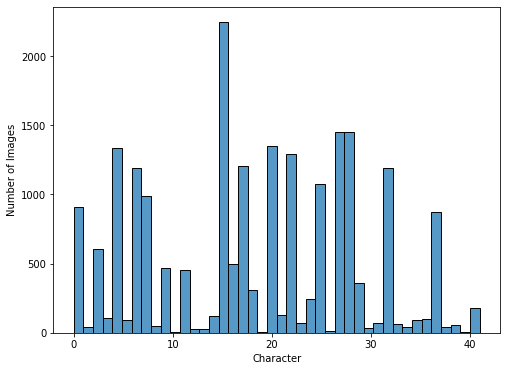

In [3]:
# Prints dictionary for reference
for key, value in translation.items():
    print(key, '=', value)

# Prints histogram
plt.figure(figsize=(8,6))
hist = sns.histplot(labels, bins=42)
hist.set(xlabel='Character', ylabel='Number of Images')

Now I will print 20 random images of the training data to provide the user with an example of it.

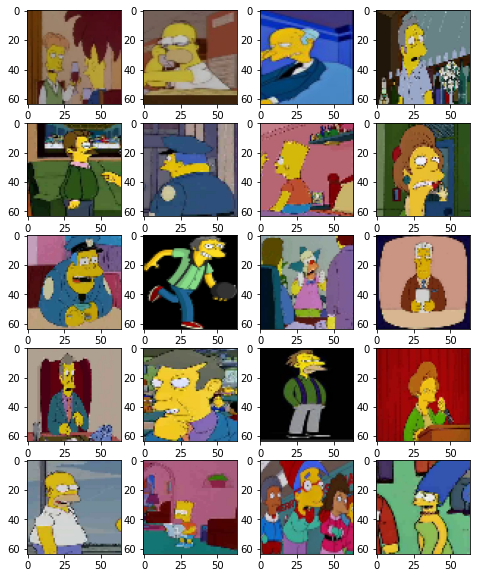

In [4]:
display = plt.figure(figsize=(8,10))
n = 1
for x in range(20):
    x = load_img(random.choice(images), target_size=IMG_SIZE)
    display.add_subplot(5,4,n)
    plt.imshow(x)
    n+=1

Now I will convert the array with the paths to all images into a numpy array so we can feed them into our model. I will use both the image preprocessing libraries 'load_img' and 'img_to_array'.

In [5]:
from tensorflow.keras.preprocessing.image import img_to_array

temp = list()

for img in images: # Iterates through all entries in the array with all image paths 
    temp_img = load_img(img, target_size=IMG_SIZE, interpolation='bicubic') 
    to_array = img_to_array(temp_img)
    temp.append(to_array)

X = np.array(temp, dtype=np.float32)
y = np.array(labels, dtype=np.float32)

classes = np.size(np.unique(y)) # Confirms number of different classes  

The below will verify that the number of classes has remained correct after processing the data.

In addition, it will show the shape of the images and labels arrays.

In [6]:
print('Number of classes = ', classes)
print('Shape of X (images) is = ', X.shape)
print('Shape of y (labels) is = ', y.shape)

Number of classes =  42
Shape of X (images) is =  (20900, 64, 64, 3)
Shape of y (labels) is =  (20900,)


Here we can see that there are a total of 20900 images, and they are 64 x 64 in size across 3 channels (RGB). The labels array has the same amount of entries, with the different classes of the images.

# Part 2 - Training the model

Now I will split those 20900 data points into training and testing images, separating the X and y arrays into 80% training data and 20% testing data.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Saves the length of the arrays for future reference
len_train = len(X_train)
len_test = len(X_test)

And the below will confirm how the arrays were divided according to the proportions mentioned above. 

In [8]:
print('Shape of training images array = ', X_train.shape)
print('Shape of training labels array = ', y_train.shape)
print('Shape of testing images array = ', X_test.shape)
print('Shape of testing labels array = ', y_test.shape)

Shape of training images array =  (16720, 64, 64, 3)
Shape of training labels array =  (16720,)
Shape of testing images array =  (4180, 64, 64, 3)
Shape of testing labels array =  (4180,)


Now I will build a sequential convolutional neural network (CNN).
The parameter choices are due to the following:

filters: Starting at a lower value early in the network architecture and increasing in deeper layers. 

kernel_size: Kernels started sized 3x3 due to size of image. With this size the model can learn larger features and then quickly reduce spacial dimensions. Images above 128x128 are recommended to have a kernel larger than 3x3 in the beginning. This value can then be reduced in deeper layers.

padding: Chosen 'SAME' to maintain spatial dimensions so the output volume size matches the input volume size. Spatial dimensions will then be reduced with max pooling.

activation: Relu was chosen since its gradient is always equal to 1, so the model can pass the maximum amount of the error though the networks during back propagation.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from functools import partial

# Sets up default parameters for Conv2D method
DefaultConv2D = partial(Conv2D, kernel_size=3, activation='relu', padding="SAME")

simps_cnn = Sequential()
simps_cnn.add(DefaultConv2D(filters=64, input_shape=(64,64,3)))
simps_cnn.add(MaxPool2D(pool_size=2))
simps_cnn.add(DefaultConv2D(filters=128))
simps_cnn.add(DefaultConv2D(filters=128))
simps_cnn.add(MaxPool2D(pool_size=2))
simps_cnn.add(DefaultConv2D(filters=256))
simps_cnn.add(DefaultConv2D(filters=256))
simps_cnn.add(MaxPool2D(pool_size=2))

# Converts input from matrix to array. Below you can see that a matrix of 8 x 8 x 256 turned into an array with size 16384 
simps_cnn.add(Flatten())

# Using BatchNormalization to normalise the inputs of each layer
# Also using Dropout so the netwrok is less likely to overfit that training data
simps_cnn.add(Dense(512))
simps_cnn.add(BatchNormalization())
simps_cnn.add(Activation('relu'))
simps_cnn.add(Dropout(0.3))

simps_cnn.add(Dense(256))
simps_cnn.add(BatchNormalization())
simps_cnn.add(Activation('relu'))
simps_cnn.add(Dropout(0.2))

simps_cnn.add(Dense(128))
simps_cnn.add(BatchNormalization())
simps_cnn.add(Activation('relu'))
simps_cnn.add(Dropout(0.1))

simps_cnn.add(BatchNormalization())
simps_cnn.add(Dense(42, activation='softmax'))

simps_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
simps_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)      

The final activation being 'softmax' is due to this programme having multiple classes. Softmax outputs a vector that represents the probability distributions of a list of potential outcomes. This information will be handy when I use the model.

The optimiser chosen was 'adam' as it is well suited for problems that are large in terms of data.

The loss function is 'sparse_categorical_crossentropy' as this is a multi-class problem, hence the output can be several different values.

Below I will use ImageDataGenerator as it quickly sets up python generators that automatically turn image files into preprocessed tensors that can be fed directly into models during training.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE=32

train_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In the 'train_datagen' variable, the rescale option normalises the image pixels to have 0 mean and standard deviation of 1.
The additional parameters is for image augmentation. The image generator randomly applies some transformation to the images, which helps augment the data set and improve generalisation.

On the 'test_datagen' variable I don't apply any augmentation, only the rescale.

In [12]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

With the flow() method I pass the data from the images and labels arrays, both for the training and testing. The batch_size indicates the amount of images to take at once. I have tested using bigger batch sizes, but it was diminushing my accuracy by doing so.

By calling the fit() method I will start training the model.
The 'steps_per_epoch' parameter tells the model how many batches of images to process before making a gradient update to the loss function.
The number of epochs chosen was after testing. At each epoch I noticed an increase in accuracy until it made no more significant differences. 

In [13]:
training = simps_cnn.fit(train_generator,
                         steps_per_epoch=len_train // BATCH_SIZE,
                         epochs = 50,
                         batch_size=BATCH_SIZE,
                         validation_data = test_generator,
                         validation_steps=len_test // BATCH_SIZE)
simps_cnn.evaluate(test_generator, verbose=1)

Epoch 1/50
522/522 [==============================] - 15s 29ms/step - loss: 3.3869 - accuracy: 0.1142 - val_loss: 3.3069 - val_accuracy: 0.1079
Epoch 2/50
522/522 [==============================] - 15s 28ms/step - loss: 3.0398 - accuracy: 0.1336 - val_loss: 3.3265 - val_accuracy: 0.1072
Epoch 3/50
522/522 [==============================] - 15s 28ms/step - loss: 2.8558 - accuracy: 0.1977 - val_loss: 2.8089 - val_accuracy: 0.2257
Epoch 4/50
522/522 [==============================] - 15s 28ms/step - loss: 2.6556 - accuracy: 0.2547 - val_loss: 2.2163 - val_accuracy: 0.3901
Epoch 5/50
522/522 [==============================] - 15s 28ms/step - loss: 2.3761 - accuracy: 0.3327 - val_loss: 2.0889 - val_accuracy: 0.4195
Epoch 6/50
522/522 [==============================] - 15s 28ms/step - loss: 2.0720 - accuracy: 0.4137 - val_loss: 1.6534 - val_accuracy: 0.5127
Epoch 7/50
522/522 [==============================] - 15s 28ms/step - loss: 1.7659 - accuracy: 0.5022 - val_loss: 1.3619 - val_accuracy:

[0.22908887267112732, 0.9397129416465759]

After 50 epochs the accuracy seemed to have stalled at around 90 to 95% accuracy which is quite good basing on the complexity of the problem.

Luckily I have an nVidia GTX 1660 Super GPU which is running the TensorFlow computations, drastically reducing the time per epoch in comparison to running then on the CPU, despite my CPU having 6 cores / 12 threads.

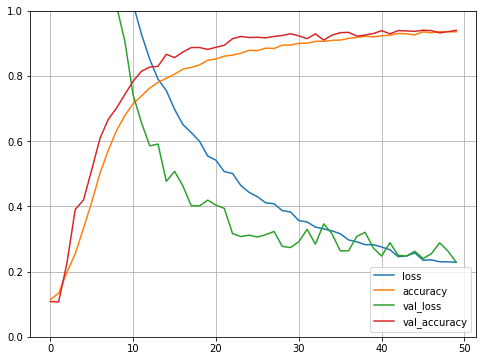

In [14]:
pd.DataFrame(training.history).plot(figsize=(8,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

The plot above shows the history of what happened during training.

It shows that the model is not overfitting as the training and testing accuracy are close together and following eachother. Normally on a overfitted model you might have a high training accuracy and lower testing one.
The same applies for the training and testing loss.

# Part 3 - Using the model

For this part of the programme I will be using the model I trained on 990 new images that do not have a label against them. These are all saved into one folder and show different characters.
I will then display an amount of them with the given classification to check if the accuracy is in line with what we got during training.

In [15]:
def load_pred_images():
    
    pred_images = list()
    pred_labels = list()
    
    for file in os.listdir(to_predict):
        temp_img = load_img(os.path.join(to_predict, file), target_size=IMG_SIZE, interpolation='bicubic') 
        to_array = img_to_array(temp_img)
        pred_images.append(to_array)
    
    return np.array(pred_images, dtype=np.float32), np.array(
        pred_labels, dtype=np.float32)

X_pred, y_pred = load_pred_images()

print(X_pred.shape)
print(y_pred.shape)

(988, 64, 64, 3)
(0,)


The defined method above is similar to ones previously used in this programme. The differences are that it just goes to the directory where all images to be predicted are stored and loads them directly as an array to the X_pred variable. The y_pred variable in this case is still empty as shown with the print statements.

In [16]:
pred_datagen = ImageDataGenerator(rescale=1./255)

The rescaling of the images to predict will also be necessary and as per the test ones, without any augmentation.

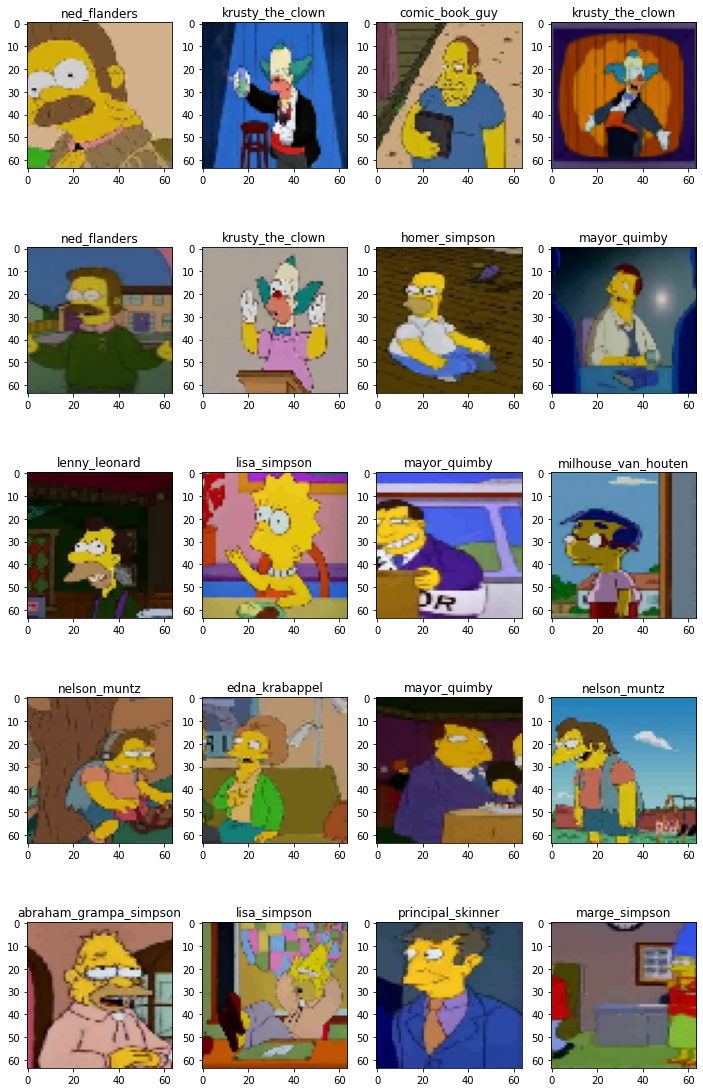

In [20]:
# Creates an array as big as the size of the predicting data, that will be used to generate random values
# which will serve as index for the display of images below.
numbers = []
index = 0
while index < len(X_pred):
    numbers.append(index)
    index += 1
random_vals = []
for x in range(20):
    random_vals.append(random.choice(numbers))

# Selects 20 indexes of images and respective labes to display below, showcasing the programme working.
display = [] 
y_pred = simps_cnn.predict(X_pred)

for pic in os.listdir(to_predict):
    display.append(os.path.join(to_predict, pic))

fig = plt.figure(figsize=(12,20))
n = 1
i = 0
for x in range(20):
    x = load_img(display[random_vals[i]], target_size=IMG_SIZE)
    fig.add_subplot(5,4,n)
    char_name = np.argmax(y_pred[random_vals[i]])
    plt.title(translation[char_name])
    plt.imshow(x)
    i += 1
    n += 1


The images above were randomly selected to be displayed, and the names were taken from the predicted labels.
The 'softmax' activation produced vectors containing the probability of the image being of a certain class. For example, one of these vectors looked like [0, 0, 0, 1, 0 ,0 .... 0, 0], meaning that the character is from the class 3. The programme then checks the dictionary previously created using key = 3, to display the name.

Other vectors were not so sure, and had values such as [0, 0, 0.25, 0 , 0, //// 0, 0.85], meaning that the last class is the most likely one to be correct. My programme looked for the highest value within these vectors and took its position in it, to find the key for the dictionary.

In [21]:
# Save the model

simps_cnn.save_weights('model_weights.h5')
simps_cnn.save('model_keras.h5')